### Utils

The util scripts are missing 2 scripts
- conversion of bbox to image relative values
- script to plot the bounding box

These scripts are available at the [***authors repo***](https://github.com/aladdinpersson/Machine-Learning-Collection/tree/master/ML/Pytorch/object_detection)

Object Localization:
 - Finding what and where a single object exists in an image

Object Detection
 - Finding what & where multiple objects are in an image





#### IOU

In [ ]:
import torch

def intersection_over_union(boxes_preds, boxes_labels, box_format="midpoint"):
  """
  Calculates intersection over union

  Parameter:
    boxes_preds (tensor): Predictions of Bounding Boxes (BATCH_SIZE, 4)
    boxes_labels (tensor): Correct labels of Bounding Boxes (BATCH_SIZE, 4)
    box_format (str): midpoints/corners if boxes (x,y,w,h) or (x1,y1,x2,y2)
  
  Returns:
    tensor: Intersection over union for all examples
  """
  # boxes_preds & boxes_labels shape is (N, 4)
  # where N is the number of bboxes
  if box_format == "midpoint":
    box1_x1 = boxes_preds[..., 0:1] - boxes_preds[..., 2:3] / 2
    box1_y1 = boxes_preds[..., 1:2] - boxes_preds[..., 3:4] / 2
    box1_x2 = boxes_preds[..., 0:1] + boxes_preds[..., 2:3] / 2
    box1_y2 = boxes_preds[..., 1:2] + boxes_preds[..., 3:4] / 2
    box2_x1 = boxes_labels[..., 0:1] - boxes_labels[..., 2:3] / 2
    box2_y1 = boxes_labels[..., 1:2] - boxes_labels[..., 3:4] / 2
    box2_x2 = boxes_labels[..., 0:1] + boxes_labels[..., 2:3] / 2
    box2_y2 = boxes_labels[..., 1:2] + boxes_labels[..., 3:4] / 2

  if box_format == "corners":
    box1_x1 = boxes_preds[..., 0:1]
    box1_y1 = boxes_preds[..., 1:2]
    box1_x2 = boxes_preds[..., 2:3]
    box1_y2 = boxes_preds[..., 3:4]
    box2_x1 = boxes_labels[..., 0:1]
    box2_y1 = boxes_labels[..., 1:2]
    box2_x2 = boxes_labels[..., 2:3]
    box2_y2 = boxes_labels[..., 3:4]

  x1 = torch.max(box1_x1, box2_x1)
  y1 = torch.max(box1_y1, box2_y1)
  x2 = torch.min(box1_x2, box2_x2)
  y2 = torch.min(box1_y2, box2_y2)

  # .clamp(0) is for the case when they do not intersect
  intersection = (x2 - x1).clamp(0) * (y2 - y1).clamp(0)

  box1_area = abs((box1_x2 - box1_x1) * (box1_y2 - box1_y1))
  box2_area = abs((box2_x2 - box2_x1) * (box2_y2 - box2_y1))

  return intersection / (box1_area + box2_area - intersection + 1e-6)

#### NMS
- discard all bboxes < probability threshold
- Take out the largest probability box
- Remove all other boxes with IOU > threshold

This has to be done for each class independently

In [ ]:
import torch

def non_max_suppression(bboxes, iou_threshold, threshold, box_format="corners"):
  # predictions = [[1, 0.9, x1, y1, x2, y2], ..]  

  assert type(bboxes) == list

  bboxes = [box for box in bboxes if box[1] > threshold]
  bboxes = sorted(bboxes, key=lambda x: x[1], reverse=True)
  bboxes_after_nms = []

  while bboxes:
    chosen_box = bboxes.pop(0)
    bboxes = [
        box
        for box in bboxes
        if box[0] != chosen_box[0]
        or intersection_over_union(
            torch.tensor(chosen_box[2:]),
            torch.tensor(box[2:]),
            box_format=box_format
        )
        < iou_threshold
    ]

    bboxes_after_nms.append(chosen_box)
  
  return bboxes_after_nms


#### Mean Average Precision
- Get all bbox predicitons on the test set
- Sort by decending confidence score
- Calculate the Precision & Recall as we go through all outputs
- Plot the Precision-Recall graph
- Calculate Area Under PR Curve

[Video Explanation](https://youtu.be/FppOzcDvaDI?list=PLhhyoLH6Ijfw0TpCTVTNk42NN08H6UvNq)

In [ ]:
# import torch
# from collections import Counter

# def mean_average_precision(
#     pred_boxes, true_boxes, 
#     iou_threshold=0.5, box_format="corners", 
#     num_classes=20
# ):

#   # pred_boxes (list): [[train_idx, class_pred, prob_score, x1, y1, x2, y2], [],...]
#   average_precisions = []
#   epsilon = 1e-6

#   for c in range(num_classes):
#     detections = []
#     ground_truths = []

#     for detection in pred_boxes:
#       if detection[1] == c:
#         detections.append(detection)
    
#     for true_box in true_boxes:
#       if true_box[1] == c:
#         ground_truths.append(true_box)
    
#     # img 0 has 3 bboxes
#     # img 1 has 5 bboxes
#     # amount_bboxes = {0:3, 1:5, ....}
#     amount_bboxes = Counter([gt[0] for gt in ground_truths])

#     for key, val in amount_bboxes.items():
#       amount_bboxes[key] = torch.zeros(val)
    
#     # amount_bboxes = {0:torch.tensor([0,0,0]), ...}
#     detections.sort(key=lambda x: x[2], reverse=True)
#     TP = torch.zeros((len(detections)))
#     FP = torch.zeros((len(detections)))
#     total_true_bboxes = len(ground_truths)

#     for detection_idx, detection in enumerate(detections):
#       ground_truth_img = [
#           bbox for bbox in ground_truths if bbox[0] == detection[0]
#       ]

#       num_gts = len(ground_truth_img)
#       best_iou = 0

#       for idx, gt in enumerate(ground_truth_img):
#         iou = intersection_over_union(
#             torch.tensor(detection[3:]),
#             torch.tensor(gt[3:]),
#             box_format=box_format)
        
#         if iou > best_iou:
#           best_iou = iou
#           best_gt_idx = idx
      
#       if best_iou > iou_threshold:
#         if amount_bboxes[detection[0]][best_gt_idx] == 0:
#           TP[detection_idx] = 1
#           amount_bboxes[detection[0]][best_gt_idx] = 1
#         else:
#           FP[detection_idx] = 1
      
#       else:
#         FP[detection_idx] = 1
    
#     # [1,1,0,1,0] -> [1,2,2,3,3]
#     TP_cumsum = torch.cumsum(TP, dim=0)
#     FP_cumsum = torch.cumsum(FP, dim=0)
#     recalls = TP_cumsum / (total_true_bboxes + epsilon)
#     precisions = torch.divide(TP_cumsum, (TP_cumsum + FP_cumsum + epsilon)) 
#     precisions = torch.cat((torch.tensor([1]), precisions))
#     recalls = torch.cat((torch.tensor([0]), recalls))
#     average_precisions.append(torch.trapz(precisions, recalls))
  
#   return sum(average_precisions) / len(average_precisions)


# """
# The above code is only for a single iou_threshold value, this function has to be called
# iteratively for different iou_thresholds (0.5, 0.55,...., 0.95).
# """
  

'\nThe above code is only for a single iou_threshold value, this function has to be called\niteratively for different iou_thresholds (0.5, 0.55,...., 0.95).\n'

In [ ]:
import torch
from collections import Counter

def mean_average_precision(
    pred_boxes, true_boxes, iou_threshold=0.5, box_format="midpoint", num_classes=20
):
    """
    Calculates mean average precision 
    Parameters:
        pred_boxes (list): list of lists containing all bboxes with each bboxes
        specified as [train_idx, class_prediction, prob_score, x1, y1, x2, y2]
        true_boxes (list): Similar as pred_boxes except all the correct ones 
        iou_threshold (float): threshold where predicted bboxes is correct
        box_format (str): "midpoint" or "corners" used to specify bboxes
        num_classes (int): number of classes
    Returns:
        float: mAP value across all classes given a specific IoU threshold 
    """

    # list storing all AP for respective classes
    average_precisions = []

    # used for numerical stability later on
    epsilon = 1e-6

    for c in range(num_classes):
        detections = []
        ground_truths = []

        # Go through all predictions and targets,
        # and only add the ones that belong to the
        # current class c
        for detection in pred_boxes:
            if detection[1] == c:
                detections.append(detection)

        for true_box in true_boxes:
            if true_box[1] == c:
                ground_truths.append(true_box)

        # find the amount of bboxes for each training example
        # Counter here finds how many ground truth bboxes we get
        # for each training example, so let's say img 0 has 3,
        # img 1 has 5 then we will obtain a dictionary with:
        # amount_bboxes = {0:3, 1:5}
        amount_bboxes = Counter([gt[0] for gt in ground_truths])

        # We then go through each key, val in this dictionary
        # and convert to the following (w.r.t same example):
        # ammount_bboxes = {0:torch.tensor[0,0,0], 1:torch.tensor[0,0,0,0,0]}
        for key, val in amount_bboxes.items():
            amount_bboxes[key] = torch.zeros(val)

        # sort by box probabilities which is index 2
        detections.sort(key=lambda x: x[2], reverse=True)
        TP = torch.zeros((len(detections)))
        FP = torch.zeros((len(detections)))
        total_true_bboxes = len(ground_truths)
        
        # If none exists for this class then we can safely skip
        if total_true_bboxes == 0:
            continue

        for detection_idx, detection in enumerate(detections):
            # Only take out the ground_truths that have the same
            # training idx as detection
            ground_truth_img = [
                bbox for bbox in ground_truths if bbox[0] == detection[0]
            ]

            num_gts = len(ground_truth_img)
            best_iou = 0

            for idx, gt in enumerate(ground_truth_img):
                iou = intersection_over_union(
                    torch.tensor(detection[3:]),
                    torch.tensor(gt[3:]),
                    box_format=box_format,
                )

                if iou > best_iou:
                    best_iou = iou
                    best_gt_idx = idx

            if best_iou > iou_threshold:
                # only detect ground truth detection once
                if amount_bboxes[detection[0]][best_gt_idx] == 0:
                    # true positive and add this bounding box to seen
                    TP[detection_idx] = 1
                    amount_bboxes[detection[0]][best_gt_idx] = 1
                else:
                    FP[detection_idx] = 1

            # if IOU is lower then the detection is a false positive
            else:
                FP[detection_idx] = 1

        TP_cumsum = torch.cumsum(TP, dim=0)
        FP_cumsum = torch.cumsum(FP, dim=0)
        recalls = TP_cumsum / (total_true_bboxes + epsilon)
        precisions = torch.divide(TP_cumsum, (TP_cumsum + FP_cumsum + epsilon))
        precisions = torch.cat((torch.tensor([1]), precisions))
        recalls = torch.cat((torch.tensor([0]), recalls))
        # torch.trapz for numerical integration
        average_precisions.append(torch.trapz(precisions, recalls))

    return sum(average_precisions) / len(average_precisions)

#### Plot Image

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from collections import Counter

def plot_image(image, boxes):
    """Plots predicted bounding boxes on the image"""
    im = np.array(image)
    height, width, _ = im.shape

    # Create figure and axes
    fig, ax = plt.subplots(1)
    # Display the image
    ax.imshow(im)

    # box[0] is x midpoint, box[2] is width
    # box[1] is y midpoint, box[3] is height

    # Create a Rectangle potch
    for box in boxes:
        box = box[2:]
        assert len(box) == 4, "Got more values than in x, y, w, h, in a box!"
        upper_left_x = box[0] - box[2] / 2
        upper_left_y = box[1] - box[3] / 2
        rect = patches.Rectangle(
            (upper_left_x * width, upper_left_y * height),
            box[2] * width,
            box[3] * height,
            linewidth=1,
            edgecolor="r",
            facecolor="none",
        )
        # Add the patch to the Axes
        ax.add_patch(rect)

    plt.show()

#### Get Bbox

In [ ]:
def get_bboxes(
    loader,
    model,
    iou_threshold,
    threshold,
    pred_format="cells",
    box_format="midpoint",
    device="cuda",
):
    all_pred_boxes = []
    all_true_boxes = []

    # make sure model is in eval before get bboxes
    model.eval()
    train_idx = 0

    for batch_idx, (x, labels) in enumerate(loader):
        x = x.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            predictions = model(x)

        batch_size = x.shape[0]
        true_bboxes = cellboxes_to_boxes(labels)
        bboxes = cellboxes_to_boxes(predictions)

        for idx in range(batch_size):
            nms_boxes = non_max_suppression(
                bboxes[idx],
                iou_threshold=iou_threshold,
                threshold=threshold,
                box_format=box_format,
            )


            #if batch_idx == 0 and idx == 0:
            #    plot_image(x[idx].permute(1,2,0).to("cpu"), nms_boxes)
            #    print(nms_boxes)

            for nms_box in nms_boxes:
                all_pred_boxes.append([train_idx] + nms_box)

            for box in true_bboxes[idx]:
                # many will get converted to 0 pred
                if box[1] > threshold:
                    all_true_boxes.append([train_idx] + box)

            train_idx += 1

    model.train()
    return all_pred_boxes, all_true_boxes


#### Convert Cell Boxes

In [ ]:
def convert_cellboxes(predictions, S=7):
    """
    Converts bounding boxes output from Yolo with
    an image split size of S into entire image ratios
    rather than relative to cell ratios. Tried to do this
    vectorized, but this resulted in quite difficult to read
    code... Use as a black box? Or implement a more intuitive,
    using 2 for loops iterating range(S) and convert them one
    by one, resulting in a slower but more readable implementation.
    """

    predictions = predictions.to("cpu")
    batch_size = predictions.shape[0]
    predictions = predictions.reshape(batch_size, 7, 7, 30)
    bboxes1 = predictions[..., 21:25]
    bboxes2 = predictions[..., 26:30]
    scores = torch.cat(
        (predictions[..., 20].unsqueeze(0), predictions[..., 25].unsqueeze(0)), dim=0
    )
    best_box = scores.argmax(0).unsqueeze(-1)
    best_boxes = bboxes1 * (1 - best_box) + best_box * bboxes2
    cell_indices = torch.arange(7).repeat(batch_size, 7, 1).unsqueeze(-1)
    x = 1 / S * (best_boxes[..., :1] + cell_indices)
    y = 1 / S * (best_boxes[..., 1:2] + cell_indices.permute(0, 2, 1, 3))
    w_y = 1 / S * best_boxes[..., 2:4]
    converted_bboxes = torch.cat((x, y, w_y), dim=-1)
    predicted_class = predictions[..., :20].argmax(-1).unsqueeze(-1)
    best_confidence = torch.max(predictions[..., 20], predictions[..., 25]).unsqueeze(
        -1
    )
    converted_preds = torch.cat(
        (predicted_class, best_confidence, converted_bboxes), dim=-1
    )

    return converted_preds

#### Cellboxes To Boxes

In [ ]:
def cellboxes_to_boxes(out, S=7):
    converted_pred = convert_cellboxes(out).reshape(out.shape[0], S * S, -1)
    converted_pred[..., 0] = converted_pred[..., 0].long()
    all_bboxes = []

    for ex_idx in range(out.shape[0]):
        bboxes = []

        for bbox_idx in range(S * S):
            bboxes.append([x.item() for x in converted_pred[ex_idx, bbox_idx, :]])
        all_bboxes.append(bboxes)

    return all_bboxes


#### Save & Load Checkpoint

In [ ]:
def save_checkpoint(state, filename="my_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    torch.save(state, filename)


def load_checkpoint(checkpoint, model, optimizer):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])

### YOLOv1

[video link](https://youtu.be/n9_XyCGr-MI?list=PLhhyoLH6Ijfw0TpCTVTNk42NN08H6UvNq)

Each grid box has the top left coordinates as (0,0) & the bottom right coordinates as (1,1)

*Each output & label will be relative to the cell*

The bbox for each cell -> [x, y, w, h] are relative to the cell.

```
x & y will have value (0,1). Whereas, w & h can have values greater than 1 because the width & height of the object can be greater than the cell size. 
```
- Predictions will look very similar but we will output two bounding boxes
  - They will specialize to output different bounding boxes (wide vs tall)

```
pred(cell) = [c1,c2,..c20,Pc1,x,y,w,h,Pc2,x,y,w,h,..]
```
Here as we are displaying the class probabilities (c1,c,..) only once even though there are 2 bboxes this means that each cell can detect only **ONE** object.

#### Model

In [ ]:
import torch
import torch.nn as nn

# Adding architecture configuration 
# Tuple: (kernel size, output filters, stride, padding)
# List: [Tuple, Tuple, Int] -> Int number of times to repeat
architecture_config = [
    (7, 64, 2, 3),
    "M",
    (3, 192, 1, 1),
    "M",
    (1, 128, 1, 0),
    (3, 256, 1, 1),
    (1, 256, 1, 0),
    (3, 512, 1, 1),
    "M",
    [(1, 256, 1, 0), (3, 512, 1, 1), 4],
    (1, 512, 1, 0),
    (3, 1024, 1, 1),
    "M",
    [(1, 512, 1, 0), (3, 1024, 1, 1), 2],
    (3, 1024, 1, 1),
    (3, 1024, 2, 1),
    (3, 1024, 1, 1),
    (3, 1024, 1, 1),
]

class CNNBlock(nn.Module):
  def __init__(self, in_channels, out_channels, **kwargs):
    super(CNNBlock, self).__init__()
    self.conv = nn.Conv2d(in_channels, out_channels, bias=False, **kwargs)
    self.batchnorm = nn.BatchNorm2d(out_channels) # At the time of YOLOv1 BN was not there but implementing anyway
    self.leakyrelu = nn.LeakyReLU(0.1)

  def forward(self, x):
    return self.leakyrelu(self.batchnorm(self.conv(x)))
  
class Yolov1(nn.Module):
  def __init__(self, in_channels=3, **kwargs):
    super(Yolov1, self).__init__()
    self.architecture = architecture_config
    self.in_channels = in_channels
    self.darknet = self._create_conv_layers(self.architecture)
    self.fcs = self._create_fcs(**kwargs)
  
  def forward(self, x):
    x = self.darknet(x)
    x = torch.flatten(x, start_dim=1) # start_dim=1 to not flatten the number of examples
    return self.fcs(x)

  def _create_conv_layers(self, architecture):
    layers = []
    in_channels = self.in_channels

    for x in architecture:
      if type(x) == tuple:
        layers.append(
            CNNBlock(
                in_channels, x[1], kernel_size=x[0], stride=x[2], padding=x[3],
            )
        )

        in_channels = x[1]
      
      elif type(x) == str:
        layers.append(
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

      elif type(x) == list:
        conv1 = x[0] # Tuple
        conv2 = x[1] # Tuple
        num_repeats = x[2] # Int

        for _ in range(num_repeats):
          layers.append(
              CNNBlock(
                  in_channels,
                  conv1[1],
                  kernel_size = conv1[0],
                  stride = conv1[2],
                  padding = conv1[3],
              )
          )

          layers.append(
              CNNBlock(
                  conv1[1],
                  conv2[1],
                  kernel_size = conv2[0],
                  stride = conv2[2],
                  padding = conv2[3],
              )
          )

          in_channels = conv2[1]
    
    return nn.Sequential(*layers)

  def _create_fcs(self, split_size, num_boxes, num_classes):
    S, B, C = split_size, num_boxes, num_classes
    return nn.Sequential(
        nn.Flatten(),
        nn.Linear(1024 * S * S, 496), # Original paper this is 4096
        nn.Dropout(0.0), # Original paper this is 0.5
        nn.LeakyReLU(0.1),
        nn.Linear(496, S * S * (C + B * 5)), # Later reshaped to (S, S, 30)
    )

# def test(S=7, B=2, C=20):
#   model = Yolov1(split_size = S, num_boxes = B, num_classes = C)
#   x = torch.randn((2, 3, 448, 448))
#   print(model(x).shape)

# test()
# '''
# output: torch.Size([2, 1470])
# '''

#### Loss Functions

We get 2 bounding box output predictions from the model but for loss function only 1 bounding box is considered.

The predicted bounding box which has the highest IOU value with the original bounding box is considered.

In [ ]:
import torch
import torch.nn as nn
# from utils import intersection_over_union

class YoloLoss(nn.Module):
  def __init__(self, S=7, B=2, C=20):
    super(YoloLoss, self).__init__()
    self.mse = nn.MSELoss(reduction="sum")
    self.S = S
    self.C = C
    self.B = B
    self.lambda_noobj = 0.5
    self.lambda_coord = 5

  def forward(self, predictions, target):
    predictions = predictions.reshape(-1, self.S, self.S, self.C + self.B * 5)

    iou_b1 = intersection_over_union(predictions[..., 21:25], target[..., 21:25])
    iou_b2 = intersection_over_union(predictions[..., 26:30], target[..., 21:25])
    ious = torch.cat([iou_b1.unsqueeze(0), iou_b2.unsqueeze(0)], dim=0)
    iou_maxes, best_box = torch.max(ious, dim=0)
    exists_box = target[..., 20].unsqueeze(3) # Iobj_i (Identity of the object)

    # ====================== #
    #   FOR BOX COORDINATE   #
    # ====================== #
    box_predictions = exists_box * (
        (
            best_box * predictions[..., 26:30]
            + (1 - best_box) * predictions[..., 21:25]
        )
    )

    box_targets = exists_box * target[..., 21:25]

    box_predictions[..., 2:4] = torch.sign(box_predictions[..., 2:4]) * torch.sqrt(
        torch.abs(box_predictions[..., 2:4] + 1e-6)
    )

    box_targets[..., 2:4] = torch.sqrt(
        box_targets[..., 2:4]
    )

    # flatten: (N,S,S,4) -> (N*S*S,4) : therefore, end_dim=-2
    box_loss = self.mse(
        torch.flatten(box_predictions, end_dim=-2),
        torch.flatten(box_targets, end_dim=-2)
    )


    # ====================== #
    #   FOR OBJECT LOSS      #
    # ====================== #
    pred_box = (
        best_box * predictions[..., 25:26] + (1 - best_box) * predictions[..., 20:21]
    )

    # (N*S*S)
    object_loss = self.mse(
        torch.flatten(exists_box * pred_box),
        torch.flatten(exists_box * target[..., 20:21])
    )

    # ====================== #
    #   FOR NO OBJECT LOSS   #
    # ====================== #
    # (N,S,S,1) -> (N, S*S)
    no_object_loss = self.mse(
        torch.flatten((1-exists_box) * predictions[..., 20:21], start_dim=1),
        torch.flatten((1-exists_box) * target[..., 20:21], start_dim=1)
    )

    no_object_loss += self.mse(
        torch.flatten((1-exists_box) * predictions[..., 25:26], start_dim=1),
        torch.flatten((1-exists_box) * target[..., 20:21], start_dim=1)
    )

    # ====================== #
    #   FOR CLASS LOSS       #
    # ====================== #

    # (N,S,S,20) -> (N*S*S, 20)
    class_loss = self.mse(
        torch.flatten(exists_box * predictions[..., :20], end_dim=-2),
        torch.flatten(exists_box * target[..., :20], end_dim=-2)
    )

    loss = (
        self.lambda_coord * box_loss # First 2 rows of loss in paper
        + object_loss
        + self.lambda_noobj * no_object_loss
        + class_loss
    )

    return loss


#### Dataset

[link](https://www.kaggle.com/datasets/734b7bcb7ef13a045cbdd007a3c19874c2586ed0b02b4afc86126e89d00af8d2) to the dataset

Create a kaggle api key & upload it to Colab

```
!pip install kaggle

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
```



In [ ]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d aladdinpersson/pascalvoc-yolo

100% 4.30G/4.31G [00:55<00:00, 69.1MB/s]
100% 4.31G/4.31G [00:55<00:00, 83.8MB/s]


In [ ]:
!unzip /content/pascalvoc-yolo.zip -d data

In [ ]:
import torch
import os
import pandas as pd
from PIL import Image

class VOCDataset(torch.utils.data.Dataset):
  def __init__(
      self, csv_file, img_dir, label_dir, S=7, B=2, C=20, transform=None
  ):
    self.annotations = pd.read_csv(csv_file)
    self.img_dir = img_dir
    self.label_dir = label_dir
    self.transform = transform
    self.S = S
    self.B = B
    self.C = C

  def __len__(self):
    return len(self.annotations)
  
  def __getitem__(self, index):
    label_path = os.path.join(self.label_dir, self.annotations.iloc[index, 1])
    boxes = []
    with open(label_path) as f:
      for label in f.readlines():
        class_label, x, y, width, height = [
            float(x) if float(x) != int(float(x)) else int(x)
            for x in label.replace("\n", "").split()
        ]

        boxes.append([class_label, x, y, width, height])
    
    img_path = os.path.join(self.img_dir, self.annotations.iloc[index, 0])
    image = Image.open(img_path)
    boxes = torch.tensor(boxes)

    if self.transform:
      image, boxes = self.transform(image, boxes)
    
    # *self.B -> the additional 5 nodes are not going to be used
    # Its there due to dependencies in other script files
    label_matrix = torch.zeros((self.S, self.S, self.C + 5*self.B)) # *self.B
    for box in boxes:
      class_label, x, y, width, height = box.tolist()
      class_label = int(class_label)
      i, j = int(self.S * y), int(self.S * x) # tricky (visualize in paper)
      x_cell, y_cell = self.S * x - j, self.S * y - i # tricky
      width_cell, height_cell = (
          width * self.S,
          height * self.S,
      )

      if label_matrix[i, j, 20] == 0:
        label_matrix[i, j, 20] = 1
        box_coordinates = torch.tensor(
            [x_cell, y_cell, width_cell, height_cell]
        )
        label_matrix[i, j, 21:25] = box_coordinates
        label_matrix[i, j, class_label] = 1

    return image, label_matrix


#### Train

=> Loading checkpoint


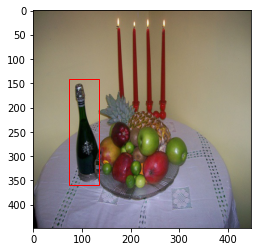

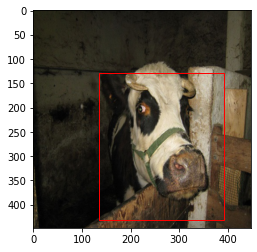

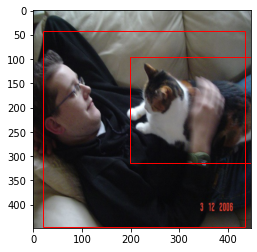

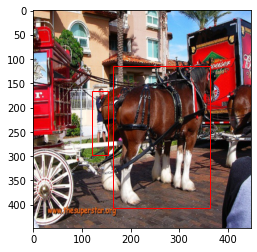

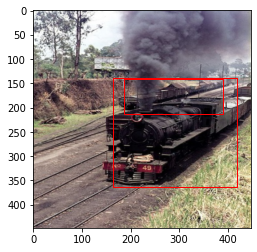

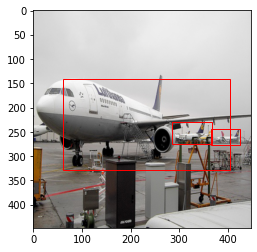

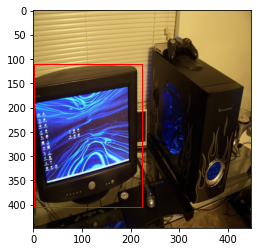

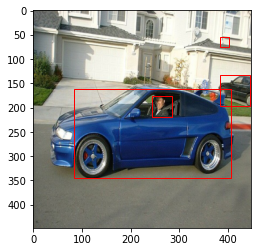

SystemExit: ignored

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3334: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [ ]:
import torch
import torchvision.transforms as transforms
import torch.optim as optim
import torchvision.transforms.functional as FT
from tqdm import tqdm
from torch.utils.data import DataLoader
# from model import Yolov1
# from dataset import VOCDataset
# from utils import(
#     intersection_over_union,
#     non_max_suppression,
#     mean_average_precision,
#     cellboxes_to_boxes,
#     get_bboxes,
#     plot_image,
#     save_checkpoint,
#     load_checkpoint,
# )
# from loss import YoloLoss

seed = 123
torch.manual_seed(seed)

# Hyperparameters etc.
LEARNING_RATE = 2e-5
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 16
WEIGHT_DECAY = 0
EPOCHS = 100
NUM_WORKERS = 2
PIN_MEMORY = True
LOAD_MODEL = False
LOAD_MODEL_FILE = "overfit.pth.tar"
IMG_DIR = "data/images"
LABEL_DIR = "data/labels"

class Compose(object):
  def __init__(self, transforms):
    self.transforms = transforms

  def __call__(self, img, bboxes):
    for t in self.transforms:
      img, bboxes = t(img), bboxes # Only resizing therefore not passing the bbox

    return img, bboxes

transform = Compose([transforms.Resize((448, 448)), transforms.ToTensor()])

def train_fn(train_loader, model, optimizer, loss_fn):
  loop = tqdm(train_loader, leave=True)
  mean_loss = []

  for batch_idx, (x, y) in enumerate(loop):
    x, y = x.to(DEVICE), y.to(DEVICE)
    out = model(x)
    loss = loss_fn(out, y)
    mean_loss.append(loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Update the progress bar
    loop.set_postfix(loss = loss.item())

  print(f"Mean loss was {sum(mean_loss)/len(mean_loss)}")


def main():
  model = Yolov1(split_size=7, num_boxes=2, num_classes=20).to(DEVICE)
  optimizer = optim.Adam(
      model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY
  )
  loss_fn = YoloLoss()

  if LOAD_MODEL:
    load_checkpoint(torch.load(LOAD_MODEL_FILE), model, optimizer)
  
  train_dataset = VOCDataset(
      "data/100examples.csv",
      transform=transform,
      img_dir=IMG_DIR,
      label_dir=LABEL_DIR,
  )

  test_dataset = VOCDataset(
      "data/test.csv",
      transform=transform,
      img_dir=IMG_DIR,
      label_dir=LABEL_DIR,
  )

  # drop_last -> If the last batch has like 2 or 3 samples (less than the batch size)
  # then don't consider it for gradient update (as it might ruin the gradient update)
  train_loader = DataLoader(
      dataset = train_dataset,
      batch_size = BATCH_SIZE,
      num_workers = NUM_WORKERS,
      pin_memory = PIN_MEMORY,
      shuffle = True,
      drop_last = True, # False, if using only 8 examples file
  )

  test_loader = DataLoader(
      dataset = test_dataset,
      batch_size = BATCH_SIZE,
      num_workers = NUM_WORKERS,
      pin_memory = PIN_MEMORY,
      shuffle = True,
      drop_last = True,
  )

  for epoch in range(EPOCHS):
    # for x, y in train_loader:
    #     x = x.to(DEVICE)
    #     for idx in range(8):
    #         bboxes = cellboxes_to_boxes(model(x))
    #         bboxes = non_max_suppression(bboxes[idx], iou_threshold=0.5, threshold=0.4, box_format="midpoint")
    #         plot_image(x[idx].permute(1,2,0).to("cpu"), bboxes)

    #     import sys
    #     sys.exit()


    pred_boxes, target_boxes = get_bboxes(
        train_loader, model, iou_threshold=0.5, threshold=0.4
    )

    mean_avg_prec = mean_average_precision(
        pred_boxes, target_boxes, iou_threshold=0.5, box_format="midpoint"
    )

    print(f"Train mAP: {mean_avg_prec}")

    if mean_avg_prec > 0.9:
      checkpoint = {
          "state_dict": model.state_dict(),
          "optimizer": optimizer.state_dict(),
      }
      save_checkpoint(checkpoint, filename=LOAD_MODEL_FILE)
      import time
      time.sleep(10)

    train_fn(train_loader, model, optimizer, loss_fn)

if __name__ == "__main__":
  main()


### YOLOv3

#### What's New in YOLOv3 ?
- ResNet Skip connections (Residual)
- Multiscale Predictions
- Can predict upto 3 objects in a cell
- Multiscales

    * Total 3 different scales
    * Small objects, Medium Objects & Large Objects
- Therefore, a total of 9 prediction for a grid.
- Smart & dynamic way for deciding anchor box size

#### Model

In [ ]:
import torch
import torch.nn as nn

"""
Information about architecture config:
Tuple is structured by (filters, kernel_size, stride) 
Every conv is a same convolution. 
List is structured by "B" indicating a residual block followed by the number of repeats
"S" is for scale prediction block and computing the yolo loss
"U" is for upsampling the feature map and concatenating with a previous layer
"""

config = [
    (32, 3, 1),
    (64, 3, 2),
    ["B", 1],
    (128, 3, 2),
    ["B", 2],
    (256, 3, 2),
    ["B", 8],
    (512, 3, 2),
    ["B", 8],
    (1024, 3, 2),
    ["B", 4],  # To this point is Darknet-53
    (512, 1, 1),
    (1024, 3, 1),
    "S",
    (256, 1, 1),
    "U",
    (256, 1, 1),
    (512, 3, 1),
    "S",
    (128, 1, 1),
    "U",
    (128, 1, 1),
    (256, 3, 1),
    "S",
]

class CNNBlock(nn.Module):
  def __init__(self, in_channels, out_channels, bn_act=True, **kwargs):
    super().__init__()
    self.conv = nn.Conv2d(in_channels, out_channels, bias=not bn_act, **kwargs)
    self.bn = nn.BatchNorm2d(out_channels)
    self.leaky = nn.LeakyReLU(0.1)
    self.use_bn_act = bn_act

  def forward(self, x):
    if self.use_bn_act:
      return self.leaky(self.bn(self.conv(x)))
    else:
      return self.conv(x)

class ResidualBlock(nn.Module):
  def __init__(self, channels, use_residual=True, num_repeats=1):
    super().__init__()
    self.layers = nn.ModuleList()
    for _ in range(num_repeats):
      self.layers += [
          nn.Sequential(
            CNNBlock(channels, channels//2, kernel_size=1),
            CNNBlock(channels//2, channels, kernel_size=3, padding=1)
          )
      ]
    
    self.use_residual = use_residual
    self.num_repeats = num_repeats
  
  def forward(self, x):
    for layer in self.layers:
      if self.use_residual:
        x = layer(x) + x
      else:
        x = layer(x)
    
    return x

class ScalePrediction(nn.Module):
  def __init__(self, in_channels, num_classes):
    super().__init__()
    self.pred = nn.Sequential(
        CNNBlock(in_channels, 2*in_channels, kernel_size=3, padding=1),
        CNNBlock(2*in_channels, 3*(num_classes + 5), bn_act=False, kernel_size=1)
    )

    self.num_classes = num_classes

  def forward(self, x):
    return (
        self.pred(x)
        .reshape(x.shape[0], 3, self.num_classes + 5, x.shape[2], x.shape[3])
        .permute(0, 1, 3, 4, 2) # moving the positions
    )

    # N x 3 x 13 x 13 x (5 + num_clasess) -> for scale 1
    # N x 3 x 26 x 26 x (5 + num_clasess) -> for scale 2
    # N x 3 x 52 x 52 x (5 + num_clasess) -> for scale 3

class YOLOv3(nn.Module):
  def __init__(self, in_channels=3, num_classes=20):
    super().__init__()
    self.num_classes = num_classes
    self.in_channels = in_channels
    self.layers = self._create_conv_layers()
  
  def forward(self, x):
    outputs = [] # 1 output for each scaled prediction
    route_connections = []

    for layer in self.layers:
      if isinstance(layer, ScalePrediction):
        outputs.append(layer(x))
        continue
      
      x = layer(x)

      if isinstance(layer, ResidualBlock) and layer.num_repeats == 8:
        route_connections.append(x)
      
      elif isinstance(layer, nn.Upsample):
        x = torch.cat([x, route_connections[-1]], dim=1)
        route_connections.pop()

    return outputs


  
  def _create_conv_layers(self):
    """
    Using list to store the layers,
      PyTorch won't be able to track the layers
      Ex. toggling eval() <-> train()
    """
    layers = nn.ModuleList()
    in_channels = self.in_channels

    for module in config:
      if isinstance(module, tuple):
        out_channels, kernel_size, stride = module
        layers.append(
            CNNBlock(
                in_channels,
                out_channels,
                kernel_size=kernel_size,
                stride=stride,
                padding=1 if kernel_size ==3 else 0
            )
        )

        in_channels = out_channels

      elif isinstance(module, list):
        num_repeats = module[1]
        layers.append(
            ResidualBlock(in_channels, num_repeats=num_repeats)
        )

      elif isinstance(module, str):
        if module == "S":
          layers += [
              ResidualBlock(in_channels, use_residual=False, num_repeats=1),
              CNNBlock(in_channels, in_channels//2, kernel_size=1),
              ScalePrediction(in_channels//2, num_classes=self.num_classes)
          ]

          in_channels = in_channels//2
        
        elif module == "U":
          layers.append(
              nn.Upsample(
                  scale_factor=2
              )
          )

          # Concatenation will happen after Upsampling
          # Therefore, the input channel will increase
          in_channels = in_channels * 3

    return layers


if __name__ == "__main__":
    num_classes = 20
    IMAGE_SIZE = 416 # Yolov1: 448, Yolov3: 416 (along with multi-scale)
    model = YOLOv3(num_classes=num_classes)
    x = torch.randn((2, 3, IMAGE_SIZE, IMAGE_SIZE))
    out = model(x)
    assert model(x)[0].shape == (2, 3, IMAGE_SIZE//32, IMAGE_SIZE//32, num_classes + 5)
    assert model(x)[1].shape ==(2, 3, IMAGE_SIZE//16, IMAGE_SIZE//16, num_classes + 5)
    assert model(x)[2].shape == (2, 3, IMAGE_SIZE//8, IMAGE_SIZE//8, num_classes + 5)
    print("Success!")



Success!


#### Dataset

In [1]:
# !mkdir -p ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !chmod 600 /root/.kaggle/kaggle.json

In [ ]:
# !kaggle datasets download -d aladdinpersson/yolov3-pretrained
# !kaggle datasets download -d aladdinpersson/pascal-voc-dataset-used-in-yolov3-video
# !kaggle datasets download -d aladdinpersson/mscocoyolov3

In [ ]:
import numpy as np
import os
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader

from PIL import Image, ImageFile
# from utils import (
#     iou_width_height as iou,
#     non_max_suppression as nms
# )

ImageFile.LOAD_TRUNCATED_IMAGES = True

class YOLODataset(Dataset):
  def __init__(self, 
               csv_file, 
               img_dir, 
               label_dir, 
               anchors, 
               image_size=416,
               S=[13,26,52],
               C=20,
               transform=None):
    
    self.annotations = pd.read_csv(csv_file)
    self.img_dir = img_dir
    self.label_dir = label_dir
    self.transform = transform
    self.S = S
    self.anchors = torch.tensor(anchors[0] + anchors[1] + anchors[2]) # for all 3 scales
    self.num_anchors = self.anchors.shape[0]
    self.num_anchors_per_scale = self.num_anchors // 3
    self.C = C
    self.ignore_iou_thresh = 0.5

  def __len__(self):
    return len(self.annotations)
  
  def __getitem__(self, index):
    label_path = os.path.join(self.label_dir, self.annotations.iloc[index, 1])
    # [class, x, y, w, h] required form -> [x, y, w, h, class]
    bboxes = np.roll(np.loadtxt(fname=label_path, delimiter=" ", ndmin=2), 4, axis=1).tolist()
    img_path = os.path.join(self.img_dir, self.annotations.iloc[index, 0])
    image = np.array(Image.open(img_path).convert('RGB'))

    if self.transform:
      # Using Albumentation
      augmentations = self.transform(image=image, bboxes=bboxes)
      image = augmentations['image']
      bboxes = augmentations['bboxes']
    
    # [p_o, x, y, w, h, c] -> therefore 6
    targets = [torch.zeros((self.num_anchors // 3, S, S, 6)) for S in self.S]

    for box in bboxes:
      iou_anchors = iou(torch.tensor(box[2:4]), self.anchors)
      anchor_indices = iou_anchors.argsort(descending=True, dim=0)
      x, y, width, height, class_label = box
      has_anchor = [False] * 3

      for anchor_idx in anchor_indices:
        # Identifying which scale
        scale_idx = anchor_idx // self.num_anchors_per_scale # 0, 1, 2
        # Identifying which anchor in that particular scale
        anchor_on_scale = anchor_idx % self.num_anchors_per_scale # 0, 1, 2
        S = self.S[scale_idx]
        i, j = int(S * y), int(S * x)
        anchor_taken = targets[scale_idx][anchor_on_scale, i, j, 0]

        if not anchor_taken and not has_anchor[scale_idx]:
          targets[scale_idx][anchor_on_scale, i, j, 0] = 1
          x_cell, y_cell = S*x - j, S*y - i # 6.5 - 6 = 0.5
          width_cell, height_cell = (
              width * S,
              height * S
          )

          box_coordinates = torch.tensor(
              [x_cell, y_cell, width_cell, height_cell]
          )
          targets[scale_idx][anchor_on_scale, i, j, 1:5] = box_coordinates
          targets[scale_idx][anchor_on_scale, i, j, 1:5] = int(class_label)
        
        elif not anchor_taken and iou_anchors[anchor_idx] > self.ignore_iou_thresh:
          targets[scale_idx][anchor_on_scale, i, j, 0] = -1 # ignore this prediciton
    
    return image, tuple(targets)


#### Loss Function

In [ ]:
import torch.nn as nn
# from utils import intersection_over_union

class YoloLoss(nn.Module):
  def __init__(self):
    super().__init__()
    self.mse = nn.MSELoss()
    self.bce = nn.BCEWithLogitsLoss()
    self.entropy = nn.CrossEntropyLoss()
    self.sigmoid = nn.Sigmoid()

    # Constants
    self.lambda_class = 1
    self.lambda_noobj = 10
    self.lambda_obj = 1
    self.lambda_box = 10

  def forward(self, predictions, target, anchors):
    obj = target[..., 0] == 1
    noobj = target[..., 0] == 0

    # No object loss
    no_object_loss = self.bce(
        (predictions[..., 0:1][noobj], (target[..., 0:1][noobj])),
    )

    # Obj loss
    anchors = anchors.reshape(1, 3, 1, 1, 2)
    box_preds = torch.cat([self.sigmoid(predictions[..., 1:3]), torch.exp(predictions[..., 3:5]) * anchors], dim=-1)
    ious = intersection_over_union(box_preds[obj], target[..., 1:5][obj]).detach()
    object_loss = self.bce((predictions[..., 0:1][obj]), (ious * target[..., 0:1]))

    # Box coordinate loss
    predictions[..., 1:3] = self.sigmoid(predictions[..., 1:3]) # x, y between [0,1]
    target[..., 3:5] = torch.log(
        (1e - 6 + target[..., 3:5] / anchors)
    )
    box_loss = self.mse(predictions[..., 1:5][obj], target[..., 1:5][obj])

    # Class loss
    class_loss = self.entropy(
        (predictions[..., 5:][obj]), (target[..., 5][obj].long())
    )

    return (
        self.lambda_box * box_loss
        + self.lambda_obj * object_loss
        + self.lambda_noobj * no_object_loss
        + self.lambda_class * class_loss
    )


#### Config

In [ ]:
import albumentations as A
import cv2
import torch

from albumentations.pytorch import ToTensorV2
# from utils import seed_everything

DATASET = 'PASCAL_VOC'
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
# seed_everything()  # If you want deterministic behavior
NUM_WORKERS = 4
BATCH_SIZE = 32
IMAGE_SIZE = 416
NUM_CLASSES = 20
LEARNING_RATE = 1e-5
WEIGHT_DECAY = 1e-4
NUM_EPOCHS = 100
CONF_THRESHOLD = 0.05
MAP_IOU_THRESH = 0.5
NMS_IOU_THRESH = 0.45
S = [IMAGE_SIZE // 32, IMAGE_SIZE // 16, IMAGE_SIZE // 8]
PIN_MEMORY = True
LOAD_MODEL = True
SAVE_MODEL = True
CHECKPOINT_FILE = "checkpoint.pth.tar"
IMG_DIR = DATASET + "/images/"
LABEL_DIR = DATASET + "/labels/"

ANCHORS = [
    [(0.28, 0.22), (0.38, 0.48), (0.9, 0.78)],
    [(0.07, 0.15), (0.15, 0.11), (0.14, 0.29)],
    [(0.02, 0.03), (0.04, 0.07), (0.08, 0.06)],
]  # Note these have been rescaled to be between [0, 1]


scale = 1.1
train_transforms = A.Compose(
    [
        A.LongestMaxSize(max_size=int(IMAGE_SIZE * scale)),
        A.PadIfNeeded(
            min_height=int(IMAGE_SIZE * scale),
            min_width=int(IMAGE_SIZE * scale),
            border_mode=cv2.BORDER_CONSTANT,
        ),
        A.RandomCrop(width=IMAGE_SIZE, height=IMAGE_SIZE),
        A.ColorJitter(brightness=0.6, contrast=0.6, saturation=0.6, hue=0.6, p=0.4),
        A.OneOf(
            [
                A.ShiftScaleRotate(
                    rotate_limit=20, p=0.5, border_mode=cv2.BORDER_CONSTANT
                ),
                A.IAAAffine(shear=15, p=0.5, mode="constant"),
            ],
            p=1.0,
        ),
        A.HorizontalFlip(p=0.5),
        A.Blur(p=0.1),
        A.CLAHE(p=0.1),
        A.Posterize(p=0.1),
        A.ToGray(p=0.1),
        A.ChannelShuffle(p=0.05),
        A.Normalize(mean=[0, 0, 0], std=[1, 1, 1], max_pixel_value=255,),
        ToTensorV2(),
    ],
    bbox_params=A.BboxParams(format="yolo", min_visibility=0.4, label_fields=[],),
)
test_transforms = A.Compose(
    [
        A.LongestMaxSize(max_size=IMAGE_SIZE),
        A.PadIfNeeded(
            min_height=IMAGE_SIZE, min_width=IMAGE_SIZE, border_mode=cv2.BORDER_CONSTANT
        ),
        A.Normalize(mean=[0, 0, 0], std=[1, 1, 1], max_pixel_value=255,),
        ToTensorV2(),
    ],
    bbox_params=A.BboxParams(format="yolo", min_visibility=0.4, label_fields=[]),
)

PASCAL_CLASSES = [
    "aeroplane",
    "bicycle",
    "bird",
    "boat",
    "bottle",
    "bus",
    "car",
    "cat",
    "chair",
    "cow",
    "diningtable",
    "dog",
    "horse",
    "motorbike",
    "person",
    "pottedplant",
    "sheep",
    "sofa",
    "train",
    "tvmonitor"
]

COCO_LABELS = ['person',
 'bicycle',
 'car',
 'motorcycle',
 'airplane',
 'bus',
 'train',
 'truck',
 'boat',
 'traffic light',
 'fire hydrant',
 'stop sign',
 'parking meter',
 'bench',
 'bird',
 'cat',
 'dog',
 'horse',
 'sheep',
 'cow',
 'elephant',
 'bear',
 'zebra',
 'giraffe',
 'backpack',
 'umbrella',
 'handbag',
 'tie',
 'suitcase',
 'frisbee',
 'skis',
 'snowboard',
 'sports ball',
 'kite',
 'baseball bat',
 'baseball glove',
 'skateboard',
 'surfboard',
 'tennis racket',
 'bottle',
 'wine glass',
 'cup',
 'fork',
 'knife',
 'spoon',
 'bowl',
 'banana',
 'apple',
 'sandwich',
 'orange',
 'broccoli',
 'carrot',
 'hot dog',
 'pizza',
 'donut',
 'cake',
 'chair',
 'couch',
 'potted plant',
 'bed',
 'dining table',
 'toilet',
 'tv',
 'laptop',
 'mouse',
 'remote',
 'keyboard',
 'cell phone',
 'microwave',
 'oven',
 'toaster',
 'sink',
 'refrigerator',
 'book',
 'clock',
 'vase',
 'scissors',
 'teddy bear',
 'hair drier',
 'toothbrush'
]